In [402]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import retrying
import requests
import numpy as np
import pandas as pd
import plotly.express as px
import json
import uuid

## Preparacion imagenes

In [441]:
NAME = "Apaporis"

In [442]:
YEAR = "2022"

In [443]:
ID_P = str(5)

In [492]:
FOLDER = "/home/oscar/greenSkySat/tiff/Apaporis/LC09_L2SP_005060_20220110_20220122_02_T1"

In [493]:
src1 = rasterio.open(f'{FOLDER}/LC09_L2SP_005060_20220110_20220122_02_T1_SR_B1.TIF')

In [494]:
src2 = rasterio.open(f'{FOLDER}/LC09_L2SP_005060_20220110_20220122_02_T1_SR_B2.TIF')

In [495]:
src3 = rasterio.open(f'{FOLDER}/LC09_L2SP_005060_20220110_20220122_02_T1_SR_B3.TIF')

In [496]:
src4 = rasterio.open(f'{FOLDER}/LC09_L2SP_005060_20220110_20220122_02_T1_SR_B4.TIF')

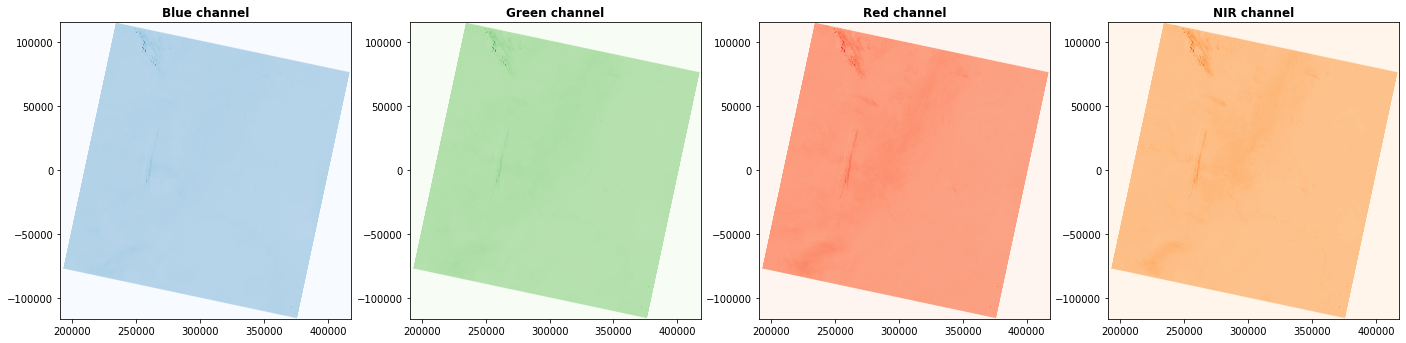

In [497]:
fig, (axb, axg, axr, axn) = plt.subplots(1,4, figsize=(24,8))
show((src1, 1), ax=axb, cmap='Blues', title='Blue channel')
show((src2, 1), ax=axg, cmap='Greens', title='Green channel')
show((src3, 1), ax=axr, cmap='Reds', title='Red channel')
show((src4, 1), ax=axn, cmap='Oranges', title='NIR channel')
plt.show()

In [498]:
band_red = src3.read(1)
band_nir = src4.read(1)

In [499]:
# correccion atmosferica de la metada de las imagenes en .xml
band_red = band_red * 1.11072
band_nir = band_nir * 1.11072

## Calculo NDVI

In [500]:
# division 0
np.seterr(divide='ignore', invalid='ignore')

# calculo NDVI
ndvi_raw = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

In [501]:
# replace nan = 0
ndvi_raw = np.nan_to_num(ndvi_raw, copy=True, nan=0.0, posinf=None, neginf=None)

In [502]:
ndvi_raw

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

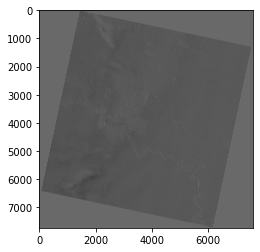

In [503]:
plt.imshow(ndvi_raw, cmap='gray');

In [504]:
band_red.shape

(7731, 7591)

In [505]:
ndvi_raw.shape

(7731, 7591)

In [506]:
# fig = px.imshow(ndvi_raw[2000:2500, 2000:2500], color_continuous_scale='RdBu', aspect='equal')
# fig.show()

## Image

In [507]:
ndvi_raw.shape

(7731, 7591)

In [508]:
ndvi = ndvi_raw[3675: 4075, 3595: 3995]

In [509]:
ndvi.shape

(400, 400)

In [510]:
colors = ['#006600', '#008800', '#00FF00', '#FFFF00', '#FFCC00', '#FF0000', '#EE0000']
fig = px.imshow(ndvi, color_continuous_scale=colors[::-1], aspect='equal')
#legend
fig.update_layout(showlegend=False)

#x axis
fig.update_xaxes(visible=False)

#y axis    
fig.update_yaxes(visible=False)
fig.write_html(f"/home/oscar/greenSkySat/html/{NAME}_{YEAR}.html")
fig.show()

In [511]:
df_ndvi = pd.DataFrame()

In [512]:
x = []
y = []
val_ndvi = []
for x_i in range(ndvi.shape[0]):
    for y_i in range(ndvi.shape[1]):
        x.append(x_i)
        y.append(y_i)
        val_ndvi.append(ndvi[x_i, y_i])

In [513]:
df_ndvi["x"] = x
df_ndvi["y"] = y
df_ndvi["ndvi"] = val_ndvi

In [514]:
df_ndvi.head()

x  y      ndvi
0  0  0 -0.025534
1  0  1 -0.026393
2  0  2 -0.029405
3  0  3 -0.027748
4  0  4 -0.030224

In [515]:
df_ndvi["ndvi"].describe()

count    160000.000000
mean         -0.033852
std           0.005324
min          -0.054297
25%          -0.038393
50%          -0.034331
75%          -0.028985
max           0.002926
Name: ndvi, dtype: float64

In [516]:
# df_ndvi.to_csv("ndvi.csv")

In [517]:
p = pd.DataFrame(df_ndvi["ndvi"].describe())

In [518]:
p = p.T

In [519]:
p

count      mean       std       min       25%       50%       75%  \
ndvi  160000.0 -0.033852  0.005324 -0.054297 -0.038393 -0.034331 -0.028985   

           max  
ndvi  0.002926

In [520]:
p["uuid_p"] = str(uuid.uuid4())

In [521]:
p["id_p"] = ID_P

In [522]:
p

count      mean       std       min       25%       50%       75%  \
ndvi  160000.0 -0.033852  0.005324 -0.054297 -0.038393 -0.034331 -0.028985   

           max                                uuid_p id_p  
ndvi  0.002926  46a395e2-e5cf-4d4d-a8a1-a7a04a930441    4

In [523]:
p.columns

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'uuid_p',
       'id_p'],
      dtype='object')

In [524]:
p = p[['count', 'mean', 'std', 'min', 'max', 'uuid_p', 'id_p']]

In [525]:
p = p.T

In [526]:
p.to_json(f"/home/oscar/greenSkySat/json/{NAME}_{YEAR}.json")